## Project idea 4:
### implement and test at least 6 different variants of Isomap for DGP: the three above, and at least three new ones of your own conception

In [218]:
#https://github.com/ffp5/Isomap_implementations

import sys
import numpy as np
import math
import types
import matplotlib.pyplot as plt
import networkx as nx
import random
from math import e
from re import M, T
import subprocess
import os
import time


### Isomap for DGP


In [219]:
def connected_graph(name,n,bool=False):
    "" "Generate a random biconnected graph with n nodes" ""
    print("we enter the function connected_graph")
    if name == "Erdos Renyi":
        # print("ER")
       X = nx.gnp_random_graph(n, 0.5, directed=False)
       while(not nx.is_connected(X)):
            X = nx.gnp_random_graph(n, 0.5, directed=False)
    elif name == "Watts Strogatz":
        # print("WS")  
        X = nx.watts_strogatz_graph(n, 3, 0.3)
        while(not nx.is_connected(X)):
             X = nx.watts_strogatz_graph(n, 3, 0.3)
    elif name == "random_regular_graph":
        # print("RRG")
        X = nx.random_regular_graph(5, n)
        while(not nx.is_connected(X)):
            X = nx.random_regular_graph(5, n)
    list_pos={}
    for u in X.nodes():
        list_pos[u]=np.random.rand(2)
    for (u, v) in X.edges():
        X[u][v]['weight'] = np.linalg.norm(list_pos[u]-list_pos[v])
    if bool:
        nx.draw(X, with_labels=True)
        plt.show()
    return X, list_pos


def create_ampl_dat_grah(D, filename):
    "" "Create a .dat file for the ampl model" ""
    with open(filename, 'w') as file:
        file.write("# gen by python\n")
        file.write("param Kdim :=" + "2" +";\n")
        file.write("param n := " + str(len(D.nodes())) + ";\n")
        file.write("param : E : c I :=\n")
        for (u, v) in D.edges():
            file.write(""+str(u+1) + " " + str(v+1) + " " + str(D[u][v]['weight'])+ " "+"1\n")
        file.write(";\n")
        file.close()

def compute_DM(method,D):
    if method=="floyd_warshall":
        D_new=floyd_warshall(D)
    elif method=="k_means":
        D_new=k_means_method(D)
    elif method=="random":
        D_new=random_method(D)
    elif method=="BFS":
        D_new=BFS(D)
    elif method=="Push-Pull" or method=="SSV":
        D_new=D
        D_new=np.zeros((D.shape[0],D.shape[0]))
        for i in range(D.shape[0]):
            for j in range(i,D.shape[0]):
                if i != j :
                    D_new[i][j]=np.linalg.norm(np.array((D[i][0],D[i][1]))-np.array((D[j][0],D[j][1])), ord=2)
                    D_new[j][i]=D_new[i][j]
    return D_new

                

# Distance matrix creation algos
def floyd_warshall(D):
    D_prime= nx.to_numpy_array(D)
    "" "Floyd-Warshall algorithm that take an nx and return an array" ""
    for i in range(D_prime.shape[0]):
        for j in range(D_prime.shape[1]):
            if i != j and D_prime[i][j] == 0:
                D_prime[i][j] = math.inf
    for k in range(D_prime.shape[0]):
        for i in range(D_prime.shape[1]):
                for j in range(D_prime.shape[0]):
                    if i != k and j != k and i !=j:
                        if D_prime[i][j] > D_prime[i][k] + D_prime[k][j]:
                            D_prime[i][j] = D_prime[i][k] + D_prime[k][j]
    if np.array_equal(D_prime, D_prime.T):
        return D_prime
    else:
        print("error:The graph is not symetric")
        return None

def dijkstra(D):
    "" "Dijkstra algorithm that take an nx and a source node s and return an array" "" 
    D_prime= nx.to_numpy_array(D)
    n = D_prime.shape[0]
    D_new=[]
    for s in range(n):
        dist = [math.inf] * n
        dist[s] = 0
        Q = [i for i in range(n)]
        while len(Q) > 0:
            u = Q[0]
            for i in Q:
                if dist[i] < dist[u]:
                    u = i
            Q.remove(u)
            for v in range(n):
                if D_prime[u][v] != 0 and dist[v] > dist[u] + D_prime[u][v]:
                    dist[v] = dist[u] + D_prime[u][v]
        D_new.append(dist)
    D_new = np.array(D_new)

    if np.array_equal(D_new, D_new.T):
        return D_new
    else:
        print("error:The graph is not symetric")
        return None
    
def dijkstra_for_kmeans(D,list):
    "" "Dijkstra algorithm that take an nx and a source node s and return an array" "" 
    D_prime= nx.to_numpy_array(D)
    n = D_prime.shape[0]
    D_new=[]
    for s in list:
        dist = [math.inf] * n
        dist[s] = 0
        Q = list.copy()
        while len(Q) > 0:
            u = Q[0]
            for i in Q:
                if dist[i] < dist[u]:
                    u = i
            Q.remove(u)
            for v in range(n):
                if D_prime[u][v] != 0 and dist[v] > dist[u] + D_prime[u][v]:
                    dist[v] = dist[u] + D_prime[u][v]
        D_new.append(dist)
    D_new = np.array(D_new)
    return D_new

def extract_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data1 = []
    data2 = []
    array=np.array([])
    for line in lines[2:]:  # Skip header lines
        row = line.split()
        if len(row) > 1:
            if ':=' in row:
                if data2==[]:
                    data2=data1.copy()
                    data1 = []
                else:
                    data2=np.concatenate((np.array(data2),np.array(data1)))
                    data1=[]
                continue
            row = [float(element) for element in row[1:]]  # Convert elements to float
            data1.append(row)
    if data1 != []:
        # print(data1)
        data2=np.concatenate((np.array(data2),np.array(data1)),axis=1)
    print(data2)
        
    return data2


## return the distance matrix of a realization
def distanceMatrix(x, p=2):
    n = len(x[:,0])
    D = np.zeros((n,n))
    for u in range(n-1):
        for v in range(u+1,n):
            D[u,v] = np.linalg.norm(np.subtract(x[u,:],x[v,:]), ord=p)
            D[v,u] = D[u,v]
    return D

## convert a distance matrix to a Gram matrix
def dist2Gram(D):
    n = D.shape[0]
    J = np.identity(n) - (1.0/n)*np.ones((n,n))
    G = -0.5 * np.dot(J,np.dot(np.square(D), J))
    return G

## factor a square matrix
def factor(A):
    n = A.shape[0]
    (evals,evecs) = np.linalg.eigh(A)
    evals[evals < 0] = 0  # closest SDP matrix
    X = evecs #np.transpose(evecs)
    sqrootdiag = np.eye(n)
    for i in range(n):
        sqrootdiag[i,i] = math.sqrt(evals[i])
    X = X.dot(sqrootdiag)
    return np.fliplr(X)

## classic Multidimensional scaling
def MDS(B, eps = 1e-9):
    n = B.shape[0]
    x = factor(B)
    (evals,evecs) = np.linalg.eigh(x)
    K = len(evals[evals > eps])
    if K < n:
        # only first K columns
        x = x[:,0:K]
    return x

## principal component analysis
def PCA(B, K):
    x = factor(B)
    n = B.shape[0]
    if isinstance(K, str):
        K = n
    if K < n:
        # only first K columns
        x = x[:,0:K]
    return x

def complete_PCA_part(D,eps,representation=True):
    G=dist2Gram(D)
    X=MDS(G,eps)
    n=X.shape[0]
    # K=X.shape[1]
    K=3
    # print("dimension can be reduced from", n, "to", K)

    if representation:
        if K > 3:
            K = 3
        elif K < 2:
            K = 2
        print("representing in", K, "dimensions")

        X = PCA(G,K)

        if K == 2:
            plt.scatter(X[:,0], X[:,1])
        elif K == 3:
            fig = plt.figure()
            ax = plt.axes(projection='3d')
            ax.scatter(X[:,0], X[:,1], X[:,2])
            ax.plot(X[:,0], X[:,1], X[:,2])
            ax.set_xlabel('x')
            ax.set_ylabel('y')
            ax.set_zlabel('z')

        plt.show()
    else:
        X=PCA(G,K)
    return X

def k_means_method(D):
    D_prime= nx.to_numpy_array(D)
    print(f'D_prime={D_prime}')

    # Obtenir le degré de chaque noeud
    degrees = D.degree()

    # Trier les noeuds par degré en ordre décroissant
    sorted_nodes = sorted(degrees, key=lambda x: x[1], reverse=True)
    
    # Les noeuds les plus connectés sont les premiers de la liste triée
    most_connected_nodes = sorted_nodes[0]
    print(f'sorted_nodes={sorted_nodes}')
    Q=[i for i in range(D_prime.shape[0])]
    centroids=[]
    reached_list=[]
    for i in range(len(sorted_nodes)):
        add=False
        if len(Q) == 0:
            break
        u = sorted_nodes[i][0]
        print(f'u={u}')
        reached=[]
        print(f'Q={Q}')
        for v in Q:
            print(f'v={v}')
            if D_prime[u][v] != 0.:
                print(f'Q={Q}')
                reached.append(v)
                add=True
        for v in reached:
            Q.remove(v)
        reached.append(u)
        if add:
            centroids.append(u)
            reached_list.append(reached)
        
    list=[u for u in centroids]

    for i,center in enumerate(list):
        for j,reached in enumerate(reached_list.copy()):
            if center in reached and i != j:
                reached_list[j].remove(center)

    path_between_centroids=dijkstra_for_kmeans(D,list)
    print(f'list={list}')
    print(f'reached_list={reached_list}')
    print(f'path_between_centroids={path_between_centroids}')

    
    for i in range(D_prime.shape[0]):
        i_centroid = list[next((index for index, sublist in enumerate(reached_list) if i in sublist), None)]
        for j in range(i+1):
            j_centroid = list[next((index for index, sublist in enumerate(reached_list) if j in sublist), None)]
            if i != j and D_prime[i][j] == 0:
                print(f"i={i}, j={j}, i_centroid={i_centroid}, j_centroid={j_centroid}")
                print(f'D_prime[i][i_centroid]={D_prime[i][i_centroid]}')
                print(f'D_prime[j][j_centroid]={D_prime[j][j_centroid]}')
                print(f'path_between_centroids[list.index(i_centroid)][list.index(j_centroid)]={path_between_centroids[list.index(i_centroid)][list.index(j_centroid)]}')
                D_prime[i][j]=D_prime[i][i_centroid]+D_prime[j][j_centroid]+path_between_centroids[list.index(i_centroid)][list.index(j_centroid)]
                D_prime[j][i]=D_prime[i][j]
            elif i != j and D_prime[i][j] != 0:
                D_prime[i][j]=D_prime[i][j]
    
    if np.array_equal(D_prime, D_prime.T):
        return D_prime
    else:
        print("error:The graph is not symetric")
        return None


def random_method(D):
    D_prime= nx.to_numpy_array(D)
    seen=[]
    u=np.random.randint(0, D_prime.shape[0])
    seen.append(u)
    while len(seen) < D_prime.shape[0]:
        # print(f'new node {u} in the seen list {seen}')
        v=0
        weight=0
        Q=[i for i in range(D_prime.shape[0])]
        # print(Q)
        Q.remove(u)
        for k in range(D_prime.shape[0]):
            if D_prime[u][k] != 0:
                Q.remove(k)
                v=k
        weight=D_prime[u][v]

        already_passed=[]
        while len(Q) > 0:
            # print(f'new node {v}, Q list {Q}')
            ancient_v=v
            for k in range(D_prime.shape[0]):
                if D_prime[u][k] == 0 and D_prime[v][k] != 0 and u != k and (k not in already_passed):
                    already_passed=[]
                    Q.remove(k)
                    v=k
                    D_prime[u][k]=weight+D_prime[v][k]
                    D_prime[k][u]=weight+D_prime[v][k]
                    weight=D_prime[u][k]
            if ancient_v==v:
                for k in range(D_prime.shape[0]):
                    if D_prime[u][k] != 0 and (k not in already_passed):
                        # print(f'case ancient_v k={k}, alredy_passed={already_passed}')
                        already_passed.append(k)
                        v=k
                        # print(v)
                        weight=D_prime[u][k]
                        break
        while True:
            u=np.random.randint(0, D_prime.shape[0])
            if u not in seen:
                seen.append(u)
                break
            # print(f'there is an error with the node {u} and the node {v}')
    return D_prime      

def highest_degree_vertex(G):
    """Find the vertex with the highest degree in G."""
    max_degree_node = max(G.nodes, key=G.degree)
    return max_degree_node

def sample_from_sphere(center, distance, dimension):
    """Sample a point from a sphere centered at 'center' with a given 'distance' in a space of 'dimension' dimensions."""
    realiz_sample = np.random.normal(size=dimension)
    realiz_sample /= np.linalg.norm(realiz_sample)  # Normalize to get a unit vector
    point = center + distance * realiz_sample
    return point

def BFS(G, K=3):
    """Modified BFS that samples each node's position in a K-dimensional space based on its connections."""
    root = highest_degree_vertex(G)
    positions = {root: np.zeros(K)}  # Starting at the origin for the root
    explored = {root}
    Q = [root]

    while Q:
        v = Q.pop(0)
        x_v = positions[v]

        for w in G.neighbors(v):
            if w not in explored:
                explored.add(w)
                dvw = G[v][w]['weight']
                x_w = sample_from_sphere(x_v, dvw, K)
                positions[w] = x_w
                Q.append(w)

    # Complete the graph by adding missing edges
    for u in G.nodes():
        for v in G.nodes():
            if u != v and not G.has_edge(u, v):
                # Add an edge with weight equal to the Euclidean distance between u and v
                distance = np.linalg.norm(positions[u] - positions[v])
                G.add_edge(u, v, weight=distance)

    return calculate_distance_matrix(positions)

def calculate_distance_matrix(positions):
    """Calculate the N x N distance matrix from the positions."""
    nodes = list(positions.keys())
    n = len(nodes)
    distance_matrix = np.zeros((n, n))

    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i != j:
                distance_matrix[i, j] = np.linalg.norm(positions[u] - positions[v])
            else:
                distance_matrix[i, j] = 0  # Distance to itself is 0

    return distance_matrix



In [220]:

def complete_isomap(method,D,eps,representation=False):
    if method=="floyd_warshall":
        D_prime=floyd_warshall(D)
    elif method=="k_means":
        D_prime=k_means_method(D)
    elif method=="random":
        D_prime=random_method(D)
    elif method=="BFS":
        D_prime=BFS(D)
    elif method=="Push-Pull":
        D_prime=D #we use already extract data ans compute_DM
    elif method=="SSV":
        D_prime=D #we use already extract data ans compute_DM
    X=complete_PCA_part(D_prime,eps,representation)
    return X

# D,list_nodes=connected_graph(10)
# create_ampl_dat_grah(D,"graph.dat")
# X=complete_isomap("floyd_warshall",D,eps=1e-4,representation=True)
# D=extract_data("./dgp_graph.rlz")


## Applicative Part

In [221]:
import subprocess
G,list_nodes=connected_graph("Erdos Renyi",10)
create_ampl_dat_grah(G,"graph.dat")

# import subprocess
# import os

# # Get the absolute path to the home directory
# home_dir = os.path.expanduser('~')

# # Define the paths to the ampl executable and the dgp.run file
# ampl_path = os.path.join(home_dir, 'ampl', 'ampl')
# dgp_run_path = './pap.run'

# # Run the subprocess
# subprocess.run([ampl_path, dgp_run_path])


# P=extract_data("./dgp_graph.rlz")

we enter the function connected_graph


UnboundLocalError: cannot access local variable 'X' where it is not associated with a value

In [ ]:
from math import dist
import torch
from torch import nn
import torch.optim as optim
import numpy as np
import random as rnd
import networkx as nx 
import matplotlib.pyplot as plt

rnd.seed(42)

class ISOPredictor(nn.Module):
    def __init__(self, k_dim, h_dim):
        super(ISOPredictor, self).__init__()
        self.h1 = nn.Linear(k_dim, h_dim)
        self.h2 = nn.Linear(h_dim, k_dim)
        self.normalize = nn.LayerNorm(k_dim)
        self.l_relu = nn.LeakyReLU(0.1)

    def forward(self, x):
        x = self.l_relu(self.h1(x))
        x = self.l_relu(self.h2(x))
        # x= self.h2(x)
        # x = self.normalize(x)
        return x

def train(model, dataloader, epochs, learning_rate):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()
    model.train()
    for epoch in range(epochs):
        for data, target in dataloader:
            optimizer.zero_grad()
            output = model(data.float())
            loss = loss_fn(output, target.float())
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

def infer(model, input_data):
    model.eval()
    with torch.no_grad():
        output = model(input_data.float())
    return output

def simulate_net_moving(current_position, mu=5, sigma=2.5):
    v_const=(np.random.uniform(-5,5),np.random.uniform(-5,5))
    # v_const=(np.random.normal(mu, sigma),np.random.normal(mu, sigma))
    next_state_pos = {node: (pos[0]+v_const[0],pos[1]+ v_const[1]) for node, pos in current_position.items()}
    # next_state_pos = {node: (pos[0]+np.random.normal(mu, sigma),pos[1]+np.random.normal(mu, sigma)) for node, pos in current_position.items()}
    # next_state_pos = {node: (pos[0]+np.random.uniform(-5,5),pos[1]+np.random.uniform(-5,5)) for node, pos in current_position.items()}
    return next_state_pos

def position_to_isomap(positions):
    nodes = list(positions.keys()) ## question what is in the nodes the different moving sensors or the different positions
    n = len(nodes)
    distance_matrix = np.zeros((n, n))
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i != j:
                distance_matrix[i, j] = np.linalg.norm(np.array(positions[u]) - np.array(positions[v])) ##make it absolute
            else:
                distance_matrix[i, j] = 0
    distance_matrix = nx.from_numpy_array(distance_matrix)
    
    isomap = complete_isomap("floyd_warshall",distance_matrix,eps=1e-4,representation=False)

    return isomap

def isomap_batcher(initial_position, initial_isomap, timeline):
    iso_batch = []
    position = initial_position
    isomap = initial_isomap
    iso_batch.append(torch.tensor(isomap.copy()))
    for t in timeline:
        position = simulate_net_moving(position, mu=5, sigma=10)
        isomap = position_to_isomap(position)
        iso_batch.append(torch.tensor(isomap.copy()))
    return iso_batch

def feed_dataloader(iso_batch):
    feed_load = [(iso_batch[i], iso_batch[i+1]) for i in range(len(iso_batch)-1)]
    return torch.utils.data.DataLoader(feed_load, batch_size=10, shuffle=True) ## why batch size =10?


def inference(model, init_position, horizon, mu=5, sigma=10, plot_loss: bool = True):
    """
    Simulates movement based on a model and tracks the Mean Squared Error (MSE) loss over time.
    
    Parameters:
    - model: The predictive model to be used for inference.
    - init_position: The initial position to start the simulation from.
    - horizon: Number of steps to simulate.
    - mu, sigma: Parameters for the simulation of movement (mean and standard deviation).
    - plot_loss: If True, plots the evolution of the MSE loss over time.
    """

    gt_position = init_position
    gt_isomap = position_to_isomap(gt_position)
    
    mse_losses = []

    for step in range(horizon):

        isomap_tensor = torch.tensor(gt_isomap.copy()).float()

        predicted_isomap = infer(model,isomap_tensor.unsqueeze(0))

        gt_position = simulate_net_moving(gt_position, mu, sigma)  
        
        gt_isomap = position_to_isomap(gt_position)
        
        # Calculate MSE loss.
        mse = torch.mean((predicted_isomap.squeeze() - torch.tensor(gt_isomap.copy()).float()) ** 2).item()
        mse_losses.append(mse)  
        
        print(f'Step {step+1}, MSE: {mse}')
        
    if plot_loss:
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, horizon + 1), mse_losses, marker='o', linestyle='-', color='blue')
        plt.title('Evolution of MSE Loss Over Time')
        plt.xlabel('Simulation Step')
        plt.ylabel('MSE Loss')
        plt.grid(True)
        plt.show()


In [ ]:
n_nodes = 10
# Dimension of ISOMAP input/output
h_dim = 64  # Dimension of hidden layer
learning_rate = 0.001
epochs = 50
timeline = np.arange(0, 1000, 1)

initial_position, initial_isomap = list_nodes, complete_isomap("floyd_warshall",G,eps=1e-4,representation=False)
# print(initial_position, initial_isomap)
k_dim = initial_isomap.shape[1]
iso_batch = isomap_batcher(initial_position, initial_isomap, timeline)
print(f'shape is {iso_batch[0].shape}')
dataloader = feed_dataloader(iso_batch)
model = ISOPredictor(k_dim, h_dim)
train(model, dataloader, epochs, learning_rate)

shape is torch.Size([10, 3])
Epoch 1, Loss: 0.025769324973225594
Epoch 2, Loss: 0.021072950214147568
Epoch 3, Loss: 0.01610974781215191
Epoch 4, Loss: 0.010911730118095875
Epoch 5, Loss: 0.006703800987452269
Epoch 6, Loss: 0.0037445088382810354
Epoch 7, Loss: 0.0021563186310231686
Epoch 8, Loss: 0.0014453231124207377
Epoch 9, Loss: 0.0010824259370565414
Epoch 10, Loss: 0.0008777062175795436
Epoch 11, Loss: 0.0007140643429011106
Epoch 12, Loss: 0.0005726778763346374
Epoch 13, Loss: 0.00046029678196646273
Epoch 14, Loss: 0.0003736234793905169
Epoch 15, Loss: 0.0003370222984813154
Epoch 16, Loss: 0.00025522871874272823
Epoch 17, Loss: 0.00021311546151991934
Epoch 18, Loss: 0.00017551469500176609
Epoch 19, Loss: 0.00017513973580207676
Epoch 20, Loss: 0.0001278737181564793
Epoch 21, Loss: 0.0001187014568131417
Epoch 22, Loss: 9.779829269973561e-05
Epoch 23, Loss: 7.502007065340877e-05
Epoch 24, Loss: 6.178249896038324e-05
Epoch 25, Loss: 5.279853940010071e-05
Epoch 26, Loss: 4.5624816266354

Step 1, MSE: 6.27306917522219e-06
Step 2, MSE: 6.27306917522219e-06
Step 3, MSE: 6.27306917522219e-06
Step 4, MSE: 6.27306917522219e-06
Step 5, MSE: 6.273068720474839e-06
Step 6, MSE: 6.27306917522219e-06
Step 7, MSE: 6.27306917522219e-06
Step 8, MSE: 6.273069629969541e-06
Step 9, MSE: 6.27306917522219e-06
Step 10, MSE: 6.27306917522219e-06
Step 11, MSE: 6.27306917522219e-06
Step 12, MSE: 6.27306917522219e-06
Step 13, MSE: 6.27306917522219e-06
Step 14, MSE: 6.27306917522219e-06
Step 15, MSE: 6.27306917522219e-06


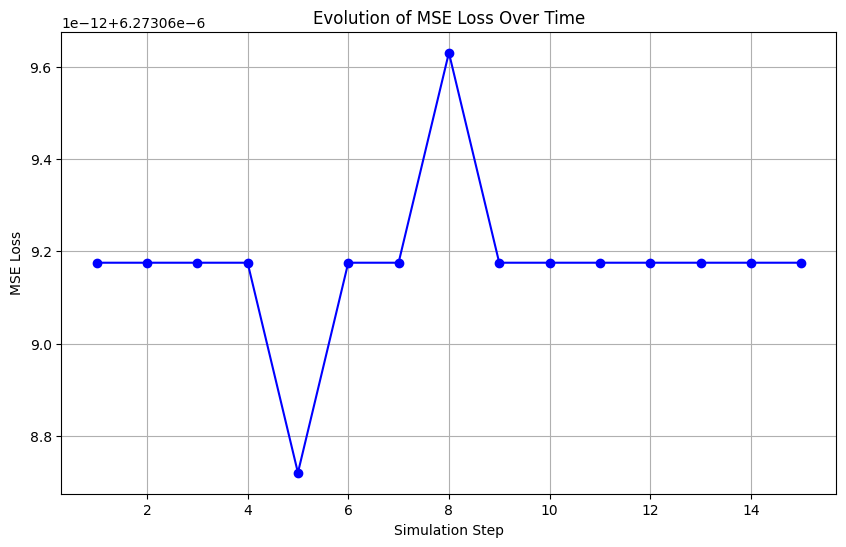

In [ ]:
#inference 
horizon = 15  # Number of steps to simulate in the future
inference(model, initial_position, horizon)

## Comparing the performance of different Isomap variants on DGP

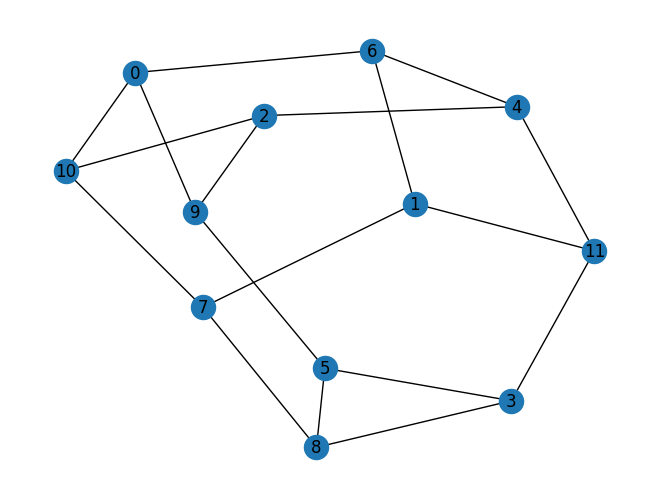

In [ ]:
def graph_generator(n):
    # G = nx.barabasi_albert_graph(n, 3)
    G = nx.random_regular_graph(3, n)
    nx.draw(G, with_labels=True)

graph_generator(12)

In [ ]:
def LDE(complete_dist_matrix, old_distance_matrix, E):
    max_deviation = -np.inf
    for i, j in E:
        d_ij_prime = complete_dist_matrix[i][j]
        d_ij = old_distance_matrix[i][j]
        deviation = np.abs(d_ij_prime - d_ij)
        max_deviation = max(max_deviation, deviation)
    return max_deviation

def MDE(complete_dist_matrix, old_distance_matrix, E):
    total_deviation = 0
    num_pairs = len(E)
    for i, j in E:
        d_ij_prime = complete_dist_matrix[i][j]
        d_ij = old_distance_matrix[i][j]
        deviation = np.abs(d_ij_prime - d_ij)
        total_deviation += deviation
    return total_deviation / num_pairs

def rmsd(complete_dist_matrix, old_distance_matrix, E) -> float:
    total_deviation = 0
    num_pairs = len(E)
    for i, j in E:
        d_ij_prime = complete_dist_matrix[i][j]
        d_ij = old_distance_matrix[i][j]
        deviation = (d_ij_prime - d_ij)**2
        total_deviation += deviation

    return np.sqrt(total_deviation / num_pairs)

def compute_measure(metric_name: str, complete_dist_matrix, old_distance_matrix, graph: nx.Graph) -> float:
    metric = 0
    E = list(graph.edges())
    if metric_name == "MDE":
        metric = MDE(complete_dist_matrix, old_distance_matrix, E)
    elif metric_name == "LDE":
        metric = LDE(complete_dist_matrix, old_distance_matrix, E)
    elif metric_name == "RMSD":
        metric = rmsd(complete_dist_matrix, old_distance_matrix, E)

    return metric


In [ ]:
def comparison_heuristics(tries_number,number_of_nodes):
    mesures=["MDE","LDE","RMSD","time"]
    heuristics=["floyd_warshall","k_means","random","BFS","Push-Pull","SSV"]
    graph_generator_method=["Erdos Renyi","Watts Strogatz","random_regular_graph"]
    comparaison_results= np.zeros((12,6))

    results = {} 

    for i,graph_gen in enumerate(graph_generator_method):
        # print(f"graph generator method {i}")
        if results != {}:
            for u,heuristic in enumerate(heuristics):
                for v,mesure in enumerate(mesures):
                    comparaison_results[v+i*4][u]=results[f'{heuristic}_{mesure}']/tries_number
            print(comparaison_results)
        results = {}

        for heuristic in heuristics:
            for mesure in mesures:
                results[f'{heuristic}_{mesure}'] = 0 #might change

        for test in range(tries_number):
            # print(f"test number {test}")
            # print(graph_gen)
            G,list_nodes=connected_graph(graph_gen,number_of_nodes)
            D=nx.to_numpy_array(G)
            for heuristic in heuristics:
                # print(f"heuristic {heuristic}")
                if heuristic=="Push-Pull":
                    create_ampl_dat_grah(G,"graph.dat")
                    # Get the absolute path to the home directory
                    home_dir = os.path.expanduser('~')
                    # Define the paths to the ampl executable and the dgp.run file
                    ampl_path = os.path.join(home_dir, 'ampl', 'ampl')
                    dgp_run_path = './pap.run'
                    # Run the subprocess
                    start_time = time.time()
                    subprocess.run([ampl_path, dgp_run_path])
                    end_time = time.time()
                    R=extract_data("./graph_pap.rlz")
                    elapsed_time_1 = end_time - start_time
                    start_time = time.time()
                    P=compute_DM(heuristic,R)
                    end_time = time.time()
                    elapsed_time_2 = end_time - start_time
                    total_time = elapsed_time_1 + elapsed_time_2
                    results[f'{heuristic}_time'] += (total_time)
                    results[f'{heuristic}_MDE'] += (compute_measure("MDE",P,D,G))
                    results[f'{heuristic}_LDE'] += (compute_measure("LDE",P,D,G))
                    results[f'{heuristic}_RMSD'] += (compute_measure("RMSD",P,D,G))
                elif heuristic=="SSV":
                    create_ampl_dat_grah(G,"graph.dat")
                    # Get the absolute path to the home directory
                    home_dir = os.path.expanduser('~')
                    # Define the paths to the ampl executable and the dgp.run file
                    ampl_path = os.path.join(home_dir, 'ampl', 'ampl')
                    dgp_run_path = './ssv.run'
                    # Run the subprocess
                    start_time = time.time()
                    subprocess.run([ampl_path, dgp_run_path])
                    end_time = time.time()
                    P=extract_data("./graph_ssv.rlz")
                    elapsed_time_1 = end_time - start_time
                    start_time = time.time()
                    P=compute_DM(heuristic,P)
                    end_time = time.time()
                    elapsed_time_2 = end_time - start_time
                    total_time = elapsed_time_1 + elapsed_time_2
                    results[f'{heuristic}_time'] += (total_time)
                    results[f'{heuristic}_MDE'] += (compute_measure("MDE",P,D,G))
                    results[f'{heuristic}_LDE'] += (compute_measure("LDE",P,D,G))
                    results[f'{heuristic}_RMSD'] += (compute_measure("RMSD",P,D,G))
                else:
                    start_time = time.time()
                    P=compute_DM(heuristic,G)
                    end_time = time.time()
                    total_time = end_time - start_time
                    results[f'{heuristic}_time'] += (total_time)
                    results[f'{heuristic}_MDE'] += (compute_measure("MDE",P,D,G))
                    results[f'{heuristic}_LDE'] += (compute_measure("LDE",P,D,G))
                    results[f'{heuristic}_RMSD'] += (compute_measure("RMSD",P,D,G))
    return comparaison_results

In [ ]:
comparison_heuristics(3,10)

we enter the function connected_graph
D_prime=[[0.         0.81532916 0.47121581 0.52602167 0.29955018 0.91626472
  0.69903843 0.35023365 0.         0.91147404]
 [0.81532916 0.         0.56757113 0.         0.         0.79545106
  0.53965901 0.48805847 0.         0.        ]
 [0.47121581 0.56757113 0.         0.         0.         0.
  0.79798861 0.22375245 0.         0.57837759]
 [0.52602167 0.         0.         0.         0.64740454 0.
  0.         0.         0.20027292 0.        ]
 [0.29955018 0.         0.         0.64740454 0.         0.
  0.95221195 0.43998482 0.76822169 0.        ]
 [0.91626472 0.79545106 0.         0.         0.         0.
  0.         0.67766433 0.93344774 0.        ]
 [0.69903843 0.53965901 0.79798861 0.         0.95221195 0.
  0.         0.58563996 0.         0.        ]
 [0.35023365 0.48805847 0.22375245 0.         0.43998482 0.67766433
  0.58563996 0.         0.35079948 0.56484874]
 [0.         0.         0.         0.20027292 0.76822169 0.93344774
  0.  

BARON 23.3.11 (2023.03.11): outlev=1
epsr=1e-3
prfreq=1e3
maxtime=30
 BARON version 23.3.11. Built: OSX-64 Sat Mar 11 18:00:27 EST 2023

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSQP
 Preprocessing found feasible solution with value 0.00000
 Doing local search
 Solving bounding LP
 Starting multi-start local search
 Preprocessing found feasible solution with value 19.3896
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
          1             1             0.21      19.3

KeyboardInterrupt: 

       2000          1001            25.83      19.3896          30.7626


we enter the function connected_graph


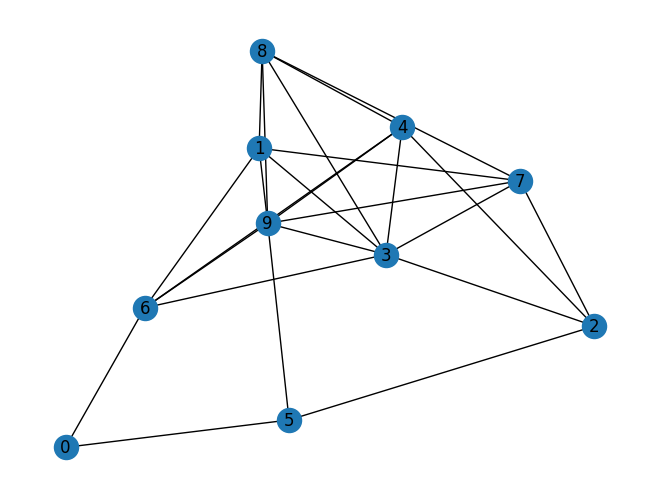

D_prime=[[0.         0.         0.         0.         0.         0.6710823
  0.86050255 0.         0.         0.        ]
 [0.         0.         0.         0.56941124 0.         0.
  0.21995405 0.60782173 0.47557903 0.98753784]
 [0.         0.         0.         0.41429741 0.11588815 0.28789695
  0.         0.4626533  0.         0.        ]
 [0.         0.56941124 0.41429741 0.         0.40333189 0.
  0.54930025 0.17611749 0.11474548 0.44001399]
 [0.         0.         0.11588815 0.40333189 0.         0.
  0.15391536 0.         0.33804791 0.79068761]
 [0.6710823  0.         0.28789695 0.         0.         0.
  0.         0.         0.         0.54824072]
 [0.86050255 0.21995405 0.         0.54930025 0.15391536 0.
  0.         0.         0.         0.90934347]
 [0.         0.60782173 0.4626533  0.17611749 0.         0.
  0.         0.         0.1595463  0.52703064]
 [0.         0.47557903 0.         0.11474548 0.33804791 0.
  0.         0.1595463  0.         0.55396828]
 [0.         0

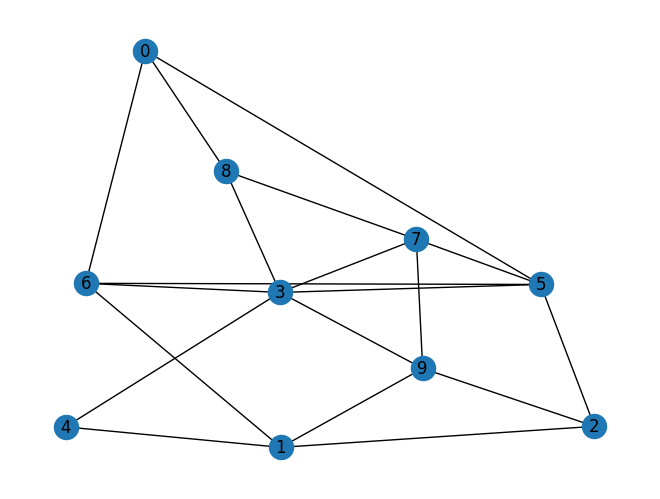

D_prime=[[0.         0.         0.         0.         0.         0.05621088
  0.08820239 0.         0.20176249 0.        ]
 [0.         0.         0.33874403 0.         0.50974983 0.
  0.23193253 0.         0.         0.55256844]
 [0.         0.33874403 0.         0.         0.         0.36729098
  0.         0.         0.         0.60308107]
 [0.         0.         0.         0.         0.43243864 0.6282375
  0.71434601 0.98218127 0.72396239 0.87122154]
 [0.         0.50974983 0.         0.43243864 0.         0.
  0.         0.         0.         0.        ]
 [0.05621088 0.         0.36729098 0.6282375  0.         0.
  0.08866901 0.53200308 0.         0.        ]
 [0.08820239 0.23193253 0.         0.71434601 0.         0.08866901
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.98218127 0.         0.53200308
  0.         0.         0.37976929 0.44818385]
 [0.20176249 0.         0.         0.72396239 0.         0.
  0.         0.37976929 0.         0.

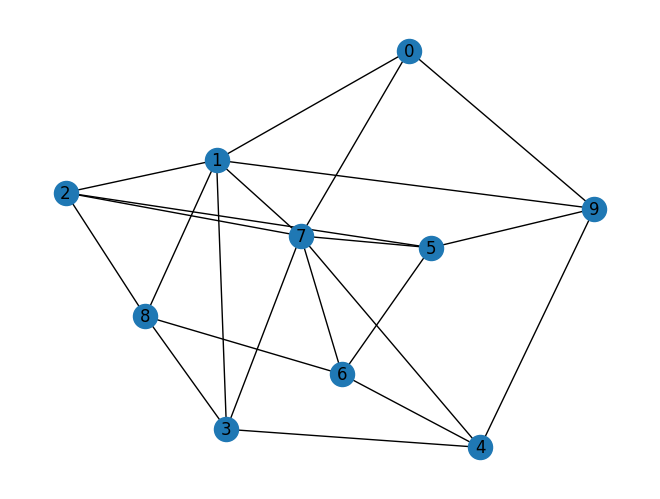

D_prime=[[0.         0.44466532 0.         0.         0.         0.
  0.         0.63409999 0.         0.35521094]
 [0.44466532 0.         0.19755557 0.27452865 0.         0.
  0.         0.36412713 0.99881914 0.13766914]
 [0.         0.19755557 0.         0.         0.         0.19923477
  0.         0.31144656 0.80800279 0.        ]
 [0.         0.27452865 0.         0.         0.44650176 0.
  0.         0.51894961 0.90577378 0.        ]
 [0.         0.         0.         0.44650176 0.         0.
  0.81963448 0.07663761 0.         0.40704644]
 [0.         0.         0.19923477 0.         0.         0.
  0.75661104 0.31971223 0.         0.18741814]
 [0.         0.         0.         0.         0.81963448 0.75661104
  0.         0.87546182 0.85153042 0.        ]
 [0.63409999 0.36412713 0.31144656 0.51894961 0.07663761 0.31971223
  0.87546182 0.         0.         0.        ]
 [0.         0.99881914 0.80800279 0.90577378 0.         0.
  0.85153042 0.         0.         0.        ]
 [0.3

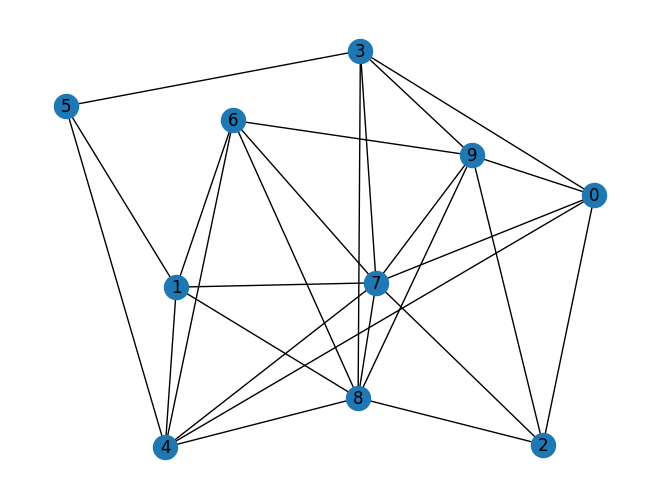

D_prime=[[0.         0.         0.67794822 0.65031059 0.17025325 0.
  0.         0.10724106 0.         0.44011836]
 [0.         0.         0.         0.         0.70647284 0.80844399
  1.02976763 0.89663866 0.91731452 0.        ]
 [0.67794822 0.         0.         0.         0.         0.
  0.         0.78040202 1.08124209 0.36526204]
 [0.65031059 0.         0.         0.         0.         0.60814093
  0.         0.66832391 0.70176644 0.39994488]
 [0.17025325 0.70647284 0.         0.         0.         0.46088912
  0.34365443 0.19893736 0.43250124 0.        ]
 [0.         0.80844399 0.         0.60814093 0.46088912 0.
  0.         0.         0.         0.        ]
 [0.         1.02976763 0.         0.         0.34365443 0.
  0.         0.14636453 0.34463615 0.66331638]
 [0.10724106 0.89663866 0.78040202 0.66832391 0.19893736 0.
  0.14636453 0.         0.36101984 0.51818992]
 [0.         0.91731452 1.08124209 0.70176644 0.43250124 0.
  0.34463615 0.36101984 0.         0.7527008 ]
 [0.4

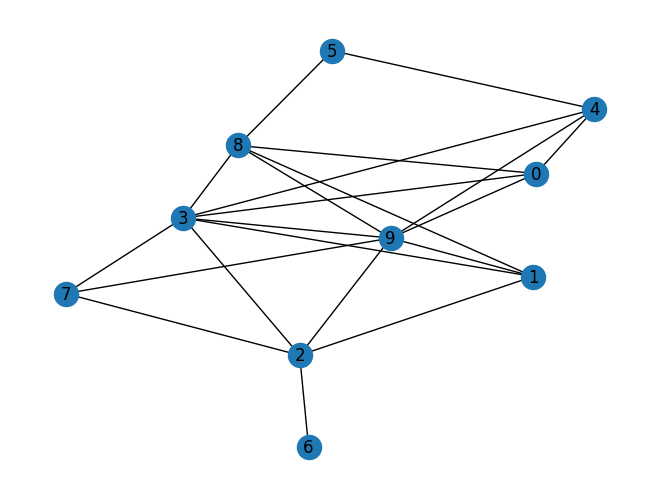

D_prime=[[0.         0.         0.         0.71606928 0.84187336 0.
  0.         0.         0.63617918 0.91733471]
 [0.         0.         0.50723374 0.49857974 0.         0.
  0.         0.         0.28770814 0.48985102]
 [0.         0.50723374 0.         0.12904492 0.         0.
  0.68907855 0.69297855 0.         0.21170031]
 [0.71606928 0.49857974 0.12904492 0.         0.23107328 0.
  0.         0.57468705 0.21881906 0.33123482]
 [0.84187336 0.         0.         0.23107328 0.         0.60728184
  0.         0.         0.         0.10061366]
 [0.         0.         0.         0.         0.60728184 0.
  0.         0.         0.53509844 0.        ]
 [0.         0.         0.68907855 0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.69297855 0.57468705 0.         0.
  0.         0.         0.         0.90358201]
 [0.63617918 0.28770814 0.         0.21881906 0.         0.53509844
  0.         0.         0.         0.28170655]
 [0.91733471 

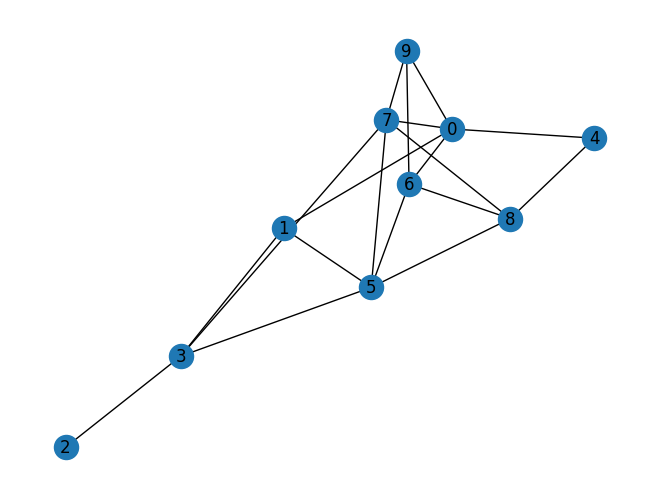

D_prime=[[0.         0.57150662 0.         0.         0.67687767 0.
  0.42226631 0.91400238 0.         0.65165256]
 [0.57150662 0.         0.         0.3836994  0.         0.19291845
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.51683288 0.         0.
  0.         0.         0.         0.        ]
 [0.         0.3836994  0.51683288 0.         0.         0.22516615
  0.         0.01789365 0.         0.        ]
 [0.67687767 0.         0.         0.         0.         0.
  0.         0.         0.4986363  0.        ]
 [0.         0.19291845 0.         0.22516615 0.         0.
  0.36531105 0.21093016 0.36530339 0.        ]
 [0.42226631 0.         0.         0.         0.         0.36531105
  0.         0.         0.30841596 0.50283198]
 [0.91400238 0.         0.         0.01789365 0.         0.21093016
  0.         0.         0.42758775 0.95157023]
 [0.         0.         0.         0.         0.4986363  0.36530339
  0.30841596 0.42758775 0.         0

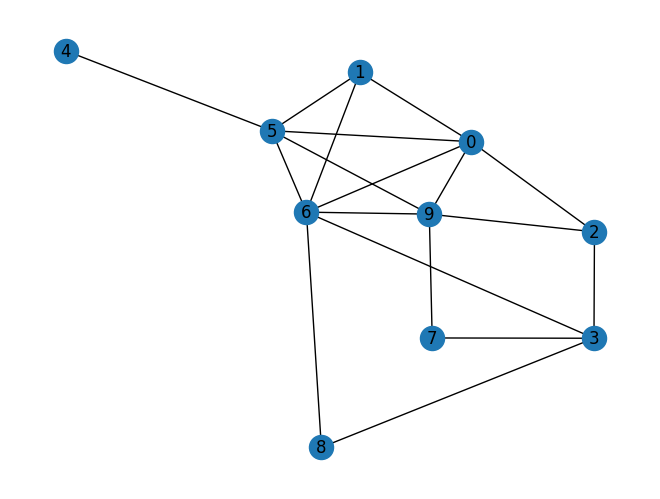

D_prime=[[0.         0.60353789 0.61754795 0.         0.         0.37660563
  0.38854832 0.         0.         0.56775073]
 [0.60353789 0.         0.         0.         0.         0.77152226
  0.30716821 0.         0.         0.        ]
 [0.61754795 0.         0.         0.66835213 0.         0.
  0.         0.         0.         0.97992569]
 [0.         0.         0.66835213 0.         0.         0.
  0.12471022 0.25762802 0.14207653 0.        ]
 [0.         0.         0.         0.         0.         0.60293254
  0.         0.         0.         0.        ]
 [0.37660563 0.77152226 0.         0.         0.60293254 0.
  0.68625216 0.         0.         0.9439531 ]
 [0.38854832 0.30716821 0.         0.12471022 0.         0.68625216
  0.         0.         0.12652083 0.4293641 ]
 [0.         0.         0.         0.25762802 0.         0.
  0.         0.         0.         0.54670182]
 [0.         0.         0.         0.14207653 0.         0.
  0.12652083 0.         0.         0.       

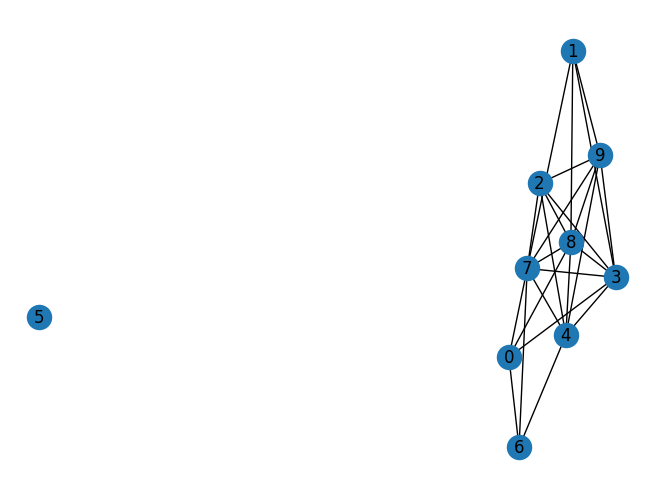

D_prime=[[0.         0.         0.         0.42262832 0.         0.
  0.81474943 0.77986122 0.84036154 0.        ]
 [0.         0.         0.         0.1363818  0.         0.
  0.         0.30540497 0.3426643  0.40012854]
 [0.         0.         0.         0.51533015 0.87483825 0.
  0.         0.69876309 0.25442449 0.64740645]
 [0.42262832 0.1363818  0.51533015 0.         0.52704586 0.
  0.         0.3980908  0.45401015 0.26602976]
 [0.         0.         0.87483825 0.52704586 0.         0.
  0.88966018 0.88750604 0.93251645 0.26449469]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.81474943 0.         0.         0.         0.88966018 0.
  0.         0.6789255  0.         0.        ]
 [0.77986122 0.30540497 0.69876309 0.3980908  0.88750604 0.
  0.6789255  0.         0.4874386  0.64704396]
 [0.84036154 0.3426643  0.25442449 0.45401015 0.93251645 0.
  0.         0.4874386  0.         0.67379644]
 [0.         0.40012854 0.647

TypeError: list indices must be integers or slices, not NoneType

In [ ]:
for i in range(12):
    X,list_pose=connected_graph("Erdos Renyi",10,True)
    P=compute_DM("k_means",X)
    print(P)